In [1]:

import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import time


In [2]:
import decoupler as dc
import pandas as pd
import sys
import pickle
import tqdm
import scipy
import matplotlib


In [3]:
# https://github.com/johannesbjork/LaCroixColoR pamplemousse
colors = ["#EA7580","#F6A1A5","#F8CD9C","#1BB6AF","#088BBE","#172869"]

# Convenience functions

In [4]:
import pickle
with open('/home/ec2-user/curation/heart_datasets/gg_250821_heart_celltype_psbulks.p', 'rb') as fp:
    ads = pickle.load( fp)

In [5]:
neuron_cts = ['Glia','glia','neuron','Neuron','neural','Neural','Schwann']

def get_df(ads,gene,setting):
    dfs = {}
    for i,dataset in enumerate(ads.keys()):
        ad = ads[dataset]
        
    
        if 'age' in ad.obs.columns:
            df = ad.obs[['donor_id','sex','age']].drop_duplicates().reset_index(drop=True).set_index('donor_id')
        elif 'Age_bin' in ad.obs.columns:
            df = ad.obs[['donor_id','sex','Age_bin']].drop_duplicates().reset_index(drop=True).set_index('donor_id')
        donor_ids = list(df.index)

        if setting == 'xist':
            filt=ad.obs['xist']=='present'
        if setting == 'cell_type':
            filt=ad.obs['cell_type'].str.contains( "|".join(neuron_cts),regex=True)
    
        df['gex_selected']=None
        df['gex_others']=None
        # mn = []
        # mnn = []
        try:
            for donor_id in donor_ids:
                filt_donor = filt&(ad.obs['donor_id']==donor_id)
                m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
                
                filt_nonneur_donor = (~filt)&(ad.obs['donor_id']==donor_id)        
                m_nonneur = np.array(ad[filt_nonneur_donor,gene].X).sum()/ad.obs.loc[filt_nonneur_donor,'psbulk_n_cells'].sum()
        
                df.loc[donor_id,'gex_selected'] = m_neur
                df.loc[donor_id,'gex_others'] = m_nonneur
        except:
            pass
        dfs[dataset]=df
    return dfs
c_neur_m = colors[0]
c_nonneur_m=colors[2]
c_neur_f = colors[5]
c_nonneur_f=colors[3]

def plot_df(dfs,gene,ax1,linthresh=1e-5,hideticklabels=False,ylabel_suffix=' average expression'):
# for i,dataset in enumerate(['tucker']):
    for i,dataset in enumerate(dfs.keys()):
        df = dfs[dataset]
        male_donors = df['sex']=='male'
        nMale = male_donors.sum()
        x = np.array([i]*nMale)
    
    
        bw = 0.14
        jit_bw = 0.01
        jit = np.random.randn(len(x))*jit_bw
        ax1.scatter(x -(bw*1.5)+jit, df.loc[male_donors,'gex_selected'],c=c_neur_m,alpha=0.4,marker='^')
        ax1.scatter(x -(bw*0.5)+jit, df.loc[male_donors,'gex_others'],c=c_nonneur_m,alpha=0.4,marker='^')
        
        female_donors = df['sex']=='female'
        nFemale = female_donors.sum()
        x = np.array([i]*nFemale)
        
        jit = np.random.randn(len(x))*jit_bw
        ax1.scatter(x +(bw*0.5)+jit, df.loc[female_donors,'gex_selected'],c=c_neur_f,alpha=0.4,marker='.')
        ax1.scatter(x + (bw*1.5)+jit, df.loc[female_donors,'gex_others'],c=c_nonneur_f,alpha=0.4,marker='.')
    
    # ax1.set_yscale('symlog',linthresh=1e-3)
    ax1.set_yscale('symlog',linthresh=linthresh)
    # ax1.set_xticks([])
    ax1.set_ylabel(r'$\it{'+gene+'}$'+ylabel_suffix)
    if hideticklabels:
        ax1.set_xticks(range(len(dfs)),[]*len(dfs),rotation=45)
    else:
        ax1.set_xticks(range(len(dfs)),list(dfs.keys()),rotation=45)

def plot_df_age(dfs,gene,ax1,linthresh=1e-5,agelim=[-2,100],
                legend=True,cmap='tab20c',ylabel_suffix=' average expression',
                sex='male',cellpop='gex_selected',ncols=1):
    colors = matplotlib.colormaps[cmap](np.linspace(0,1,len(dfs)))
    ax1.set_prop_cycle('color', colors)

    for i,dataset in enumerate(dfs.keys()):
        print(dataset)
        df = dfs[dataset]
        donors = df['sex']==sex
        n_donors = donors.sum()
    
        if 'age' in df.columns:
            x = df.loc[donors,'age'].values
        elif 'Age_bin' in df.columns:
            x1 = df.loc[donors,'Age_bin'].str.split('-').str[1].astype(float)
            x2 = df.loc[donors,'Age_bin'].str.split('-').str[0].astype(float)
            x = (x1+x2)/2
            x = x.values

        # print(x)
        bw = 0.14
        jit_bw = 0.5
        jit = np.random.randn(len(x))*jit_bw
        x+=jit
        # print(donors)
        # print(cellpop)
        ax1.scatter(x, df.loc[donors,cellpop],alpha=0.4,label=dataset)
            
    ax1.set_yscale('symlog',linthresh=linthresh)
    # ax1.set_xticks([])
    ax1.set_ylabel(r'$\it{'+gene+'}$'+ylabel_suffix)
    ax1.set_xlim(agelim)
    if legend: ax1.legend(ncols=ncols)
    ax1.set_xlabel('Donor age')
    # if hideticklabels:
    #     ax1.set_xticks(range(len(dfs)),[]*len(dfs),rotation=45)
    # else:
    #     ax1.set_xticks(range(len(dfs)),list(dfs.keys()),rotation=45)

In [6]:
# len(dfs['chaffin'].query('sex=="male"  & gex_selected>0'))

In [7]:
# len(dfs['chaffin'].query('sex=="male"'))

In [8]:
# sum([len(dfs[x].query('sex=="male" & gex_selected>0')) for x in dfs.keys()])

# Plotting

In [9]:
ads['brener'].obs

,donor_id,cell_type,predicted_doublets,Virus,Condition,sex,age,psbulk_n_cells,psbulk_counts
10_144396-RV_Adipocyte,10_144396-RV,Adipocyte,False,Covid,Microthrombi,male,71,32.0,74936.0
10_144421-RV_Adipocyte,10_144421-RV,Adipocyte,False,Covid,No_Microthrombi,male,63,7.0,70986.0
11_144422-RV_Adipocyte,11_144422-RV,Adipocyte,False,Covid,No_Microthrombi,male,68,96.0,932311.0
13_144471-RV_Adipocyte,13_144471-RV,Adipocyte,False,Covid,No_Microthrombi,male,65,54.0,649241.0
15_144548-RV_Adipocyte,15_144548-RV,Adipocyte,False,Covid,No_Microthrombi,female,69,406.0,3114406.0
...,...,...,...,...,...,...,...,...,...
8_144391-RV_Unknown 1,8_144391-RV,Unknown 1,False,Covid,Microthrombi,male,83,35.0,127199.0
10_144396-RV_Unknown 2,10_144396-RV,Unknown 2,False,Covid,Microthrombi,male,71,51.0,28592.0
11_144422-RV_Unknown 2,11_144422-RV,Unknown 2,False,Covid,No_Microthrombi,male,68,3.0,1147.0
16_144608-RV_Unknown 2,16_144608-RV,Unknown 2,False,Covid,Microthrombi,male,58,25.0,15882.0


/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()


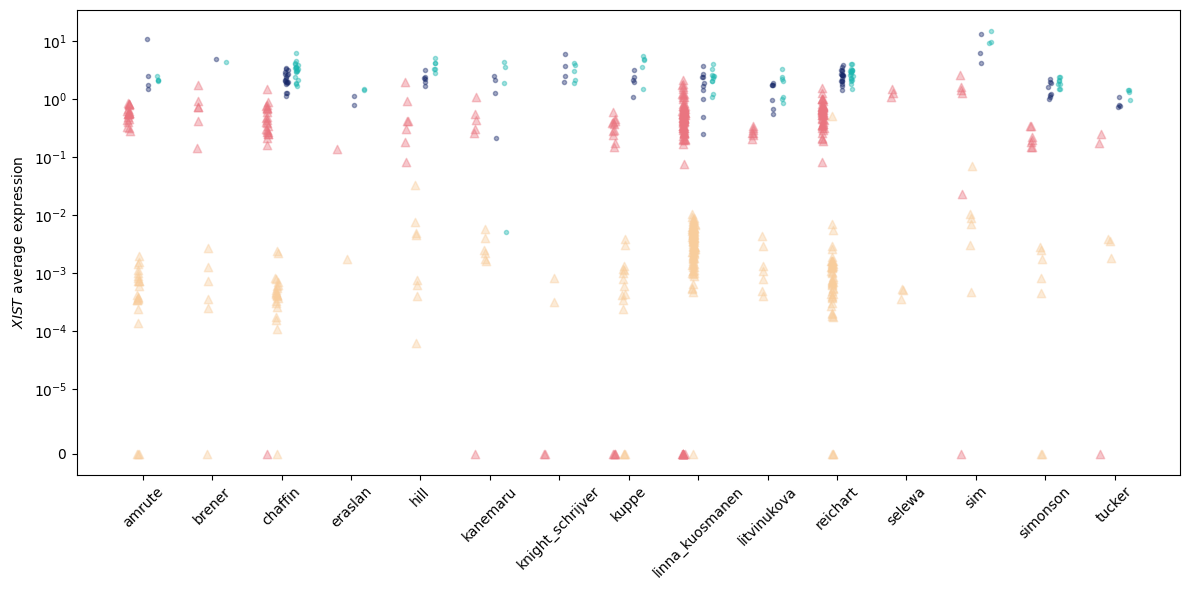

In [10]:
gene='XIST'
dfs = get_df(ads,gene,'cell_type')
fig1,ax1=plt.subplots(1,1,figsize=(12,6))
plot_df(dfs,gene,ax1,hideticklabels=False)
fig1.tight_layout()

In [13]:
df = pd.concat(list(dfs.values()))

In [14]:
len(dfs)

15

In [15]:
print((df.query('sex=="male"')['gex_selected']>0.01).sum())
print((df.query('sex=="male"')['gex_selected']<=0.01).sum())
# print((df['gex_selected']<=0.01).sum())

226
18


In [16]:
print((df.query('sex=="male"')['gex_selected']>0.01).sum())
print((df.query('sex=="male"')['gex_selected']<=0.01).sum())
# print((df['gex_selected']<=0.01).sum())

226
18


In [17]:
len(df.query('sex=="male"'))

248

/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()


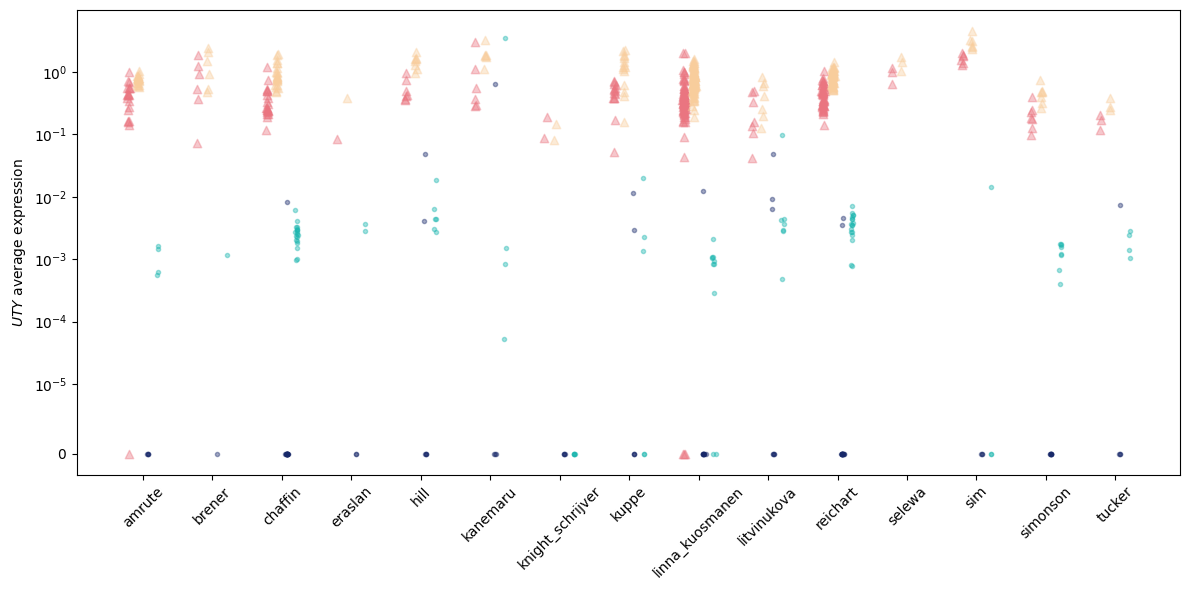

In [18]:
gene='UTY'
dfs = get_df(ads,gene,'cell_type')
fig1,ax1=plt.subplots(1,1,figsize=(12,6))
plot_df(dfs,gene,ax1,hideticklabels=False)
fig1.tight_layout()

/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:

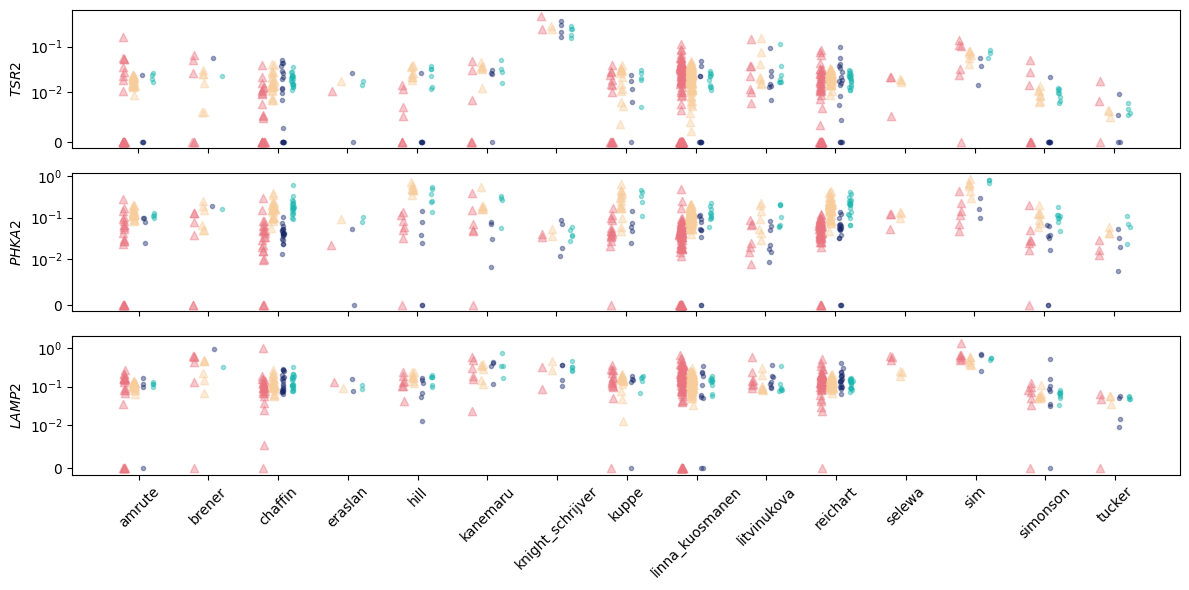

In [19]:
genes=['TSR2','PHKA2','LAMP2']
fig1,ax1=plt.subplots(3,1,figsize=(12,6))
for i,gene in enumerate(genes):
    dfs = get_df(ads,gene,'cell_type')
    
    plot_df(dfs,gene,ax1[i],hideticklabels=(i<(len(genes)-1)),linthresh=1e-2,ylabel_suffix='')
fig1.tight_layout()

/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:

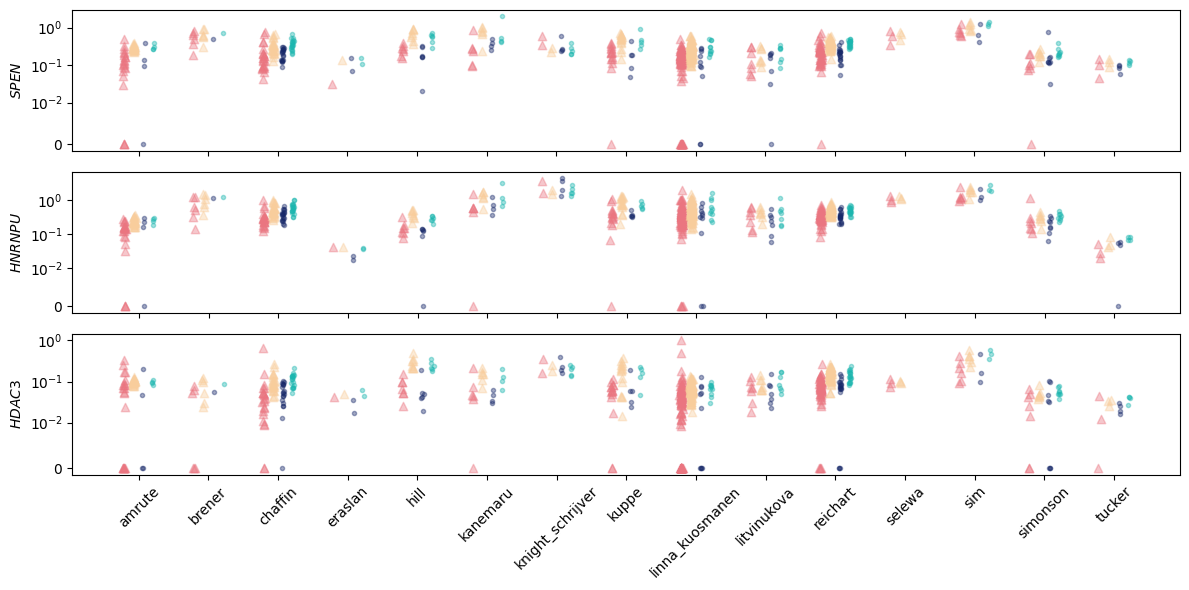

In [20]:
genes=['SPEN','HNRNPU','HDAC3']
fig1,ax1=plt.subplots(3,1,figsize=(12,6))
for i,gene in enumerate(genes):
    dfs = get_df(ads,gene,'cell_type')
    
    plot_df(dfs,gene,ax1[i],hideticklabels=(i<(len(genes)-1)),linthresh=1e-2,ylabel_suffix='')
fig1.tight_layout()

In [21]:
# plt.legend?

/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_24405/2228985470.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()


amrute
brener
chaffin
eraslan
hill
kanemaru
knight_schrijver
kuppe
linna_kuosmanen
litvinukova
reichart
selewa
sim
simonson
tucker


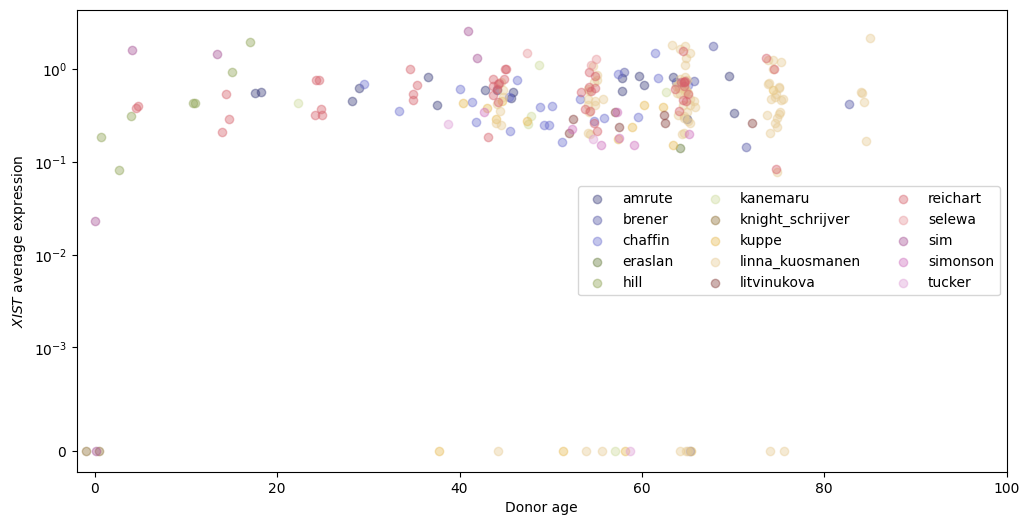

In [22]:
gene='XIST'
dfs = get_df(ads,gene,'cell_type')
fig1,ax1=plt.subplots(1,1,figsize=(12,6))
plot_df_age(dfs,gene,ax1,legend=True,cmap='tab20b',linthresh=1e-3,ncols=3)

In [23]:
x=[len(x) for x in dfs.values()]

In [24]:
sum(x)

344

In [25]:
sum([len(x[x['sex']=='male']) for x in dfs.values()])
# sum([len(x[x['sex']=='female']) for x in dfs.values()])

248

In [26]:
dfs['sim']

,sex,age,gex_selected,gex_others
donor_id,,,,
SAMN15889151,male,14.0,1.448,0.007079
SAMN15889152,female,10.0,4.114286,9.53367
SAMN15889153,male,4.0,1.593137,0.008901
SAMN15889154,female,0,13.045872,14.836561
SAMN15889155,male,0,0.023077,0.000475
SAMN15889156,male,0,0.0,0.003004
SAMN15889157,male,42.0,1.285714,0.069797
SAMN15889158,male,41.0,2.55814,0.01045
SAMN15889159,female,35.0,6.163636,9.14216


In [27]:
sum(x)

344